In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from torch.utils.data import Dataset
import torch
import os
import random
import numpy as np
from torch import nn
from typing import Dict, Optional, Tuple, List
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, random_split
from datasets import Dataset as _Dataset, DatasetDict
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import precision_score, f1_score, recall_score, classification_report

import time
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import gc

from src.data_loader import *
from src.qa_dataset import *
from src.train import *
from src.classifiers import *
from src.graph import *

os.environ['WANDB_DISABLED'] = 'true'

/home/razvor/anaconda3/envs/unsloth_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    #model_name = "unsloth/llama-3-8b-bnb-4bit",
    model_name = "models/lora_model_0",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth: Fast Llama patching release 2024.4
   \\   /|    GPU: NVIDIA GeForce RTX 4080 SUPER. Max memory: 15.992 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.2. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. Xformers = 0.0.25.post1. FA = True.
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Unsloth 2024.4 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [3]:
train_df = pd.read_csv('./data/train.csv')
dev_df = pd.read_csv('./data/dev.csv')
test_df = pd.read_csv('./data/test.csv')

In [4]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{}

### Input:
{}

### Response:
{}"""

expert_instruction = "Explain your answer briefly. No more than 20 words"

In [5]:
def process_questions(questions):
    return [
        alpaca_prompt.format(expert_instruction, q, "")
        for q in questions
    ]

def process_answers(questions, inputs, answers):
    res = {}
    for q, i, a in zip(questions, inputs, answers):
        aa = a.\
            replace(tokenizer.pad_token, '').\
            replace('<|begin_of_text|>', '').\
            replace(i, '')

        res[q] = aa

    return res
    

In [6]:
def run_batch_gen(input_q, input_texts, BS = 64):
    tokenizer.pad_token = "<|end_of_text|>"
    tokenizer.padding_side = "left"
    
    decoded_answers = []
    
    for batch_start in (tqdm(range(0, len(input_texts), BS))):
        input_texts_i = input_texts[batch_start:batch_start+BS]
        inputs = tokenizer(input_texts_i, return_tensors = "pt", padding = True).to("cuda")
        outputs = model.generate(**inputs, max_new_tokens = 256, use_cache = True, early_stopping=True, do_sample = True)
        decoded = tokenizer.batch_decode(outputs)
        decoded_answers += decoded

    return process_answers(input_q, input_texts, decoded_answers)
        

In [7]:
"""input_texts = train_df.question.unique().tolist()
input_texts = process_questions(input_texts)

tokenizer.pad_token = "<|end_of_text|>"
tokenizer.padding_side = "left"

BS = 50

decoded_answers = []

for batch_start in tqdm(tqdm(range(0, len(input_texts), BS))):
    input_texts_i = input_texts[batch_start:batch_start+BS]
    inputs = tokenizer(input_texts_i, return_tensors = "pt", padding = True).to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 256, use_cache = True, early_stopping=True, do_sample = True)
    decoded = tokenizer.batch_decode(outputs)
    decoded_answers += decoded"""

'input_texts = train_df.question.unique().tolist()\ninput_texts = process_questions(input_texts)\n\ntokenizer.pad_token = "<|end_of_text|>"\ntokenizer.padding_side = "left"\n\nBS = 50\n\ndecoded_answers = []\n\nfor batch_start in tqdm(tqdm(range(0, len(input_texts), BS))):\n    input_texts_i = input_texts[batch_start:batch_start+BS]\n    inputs = tokenizer(input_texts_i, return_tensors = "pt", padding = True).to("cuda")\n    outputs = model.generate(**inputs, max_new_tokens = 256, use_cache = True, early_stopping=True, do_sample = True)\n    decoded = tokenizer.batch_decode(outputs)\n    decoded_answers += decoded'

In [8]:
train_q = train_df.question.unique().tolist()
train_q_proc = process_questions(train_q)

qa_expert_train = run_batch_gen(
    train_q,
    train_q_proc
)

100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [19:21<00:00, 23.24s/it]


In [9]:
gc.collect()
torch.cuda.empty_cache()

In [10]:
dev_q = dev_df.question.unique().tolist()
qa_expert_dev = run_batch_gen(
    dev_q,
    process_questions(dev_q)
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 6/6 [02:20<00:00, 23.39s/it]


In [11]:
print(list(qa_expert_train.keys())[2])
print(list(qa_expert_train.values())[2])

Whom did Billy Jean King beat in the 1973 Battle of The Sexes Tennis Match?
"Bobby Riggs." King beat Riggs in an exhibition match of men's tennis on September 20, 1973 at the Houston Astrodome in Houston, Texas. The outcome was largely symbolic, with King showing that men's tennis was not exclusively a male domain. The match became a media sensation and elevated King's profile in women's tennis, a sport that still faced widespread public derision of its perceived lesser level of play than its male counterpart. King's success in the match also spurred major social conversations about gender equality and paved the way for greater female involvement in sporting events.


In [12]:
list(qa_expert_dev.keys())[4]

'Who won two Pulitzer Prizes for fiction and was born in Reading, PA?'

In [13]:
dev_df['expert1'] = dev_df.question.map(qa_expert_dev)
train_df['expert1'] = train_df.question.map(qa_expert_train)

In [15]:
dev_df.to_csv('./data/dev.csv', index=False)
train_df.to_csv('./data/train.csv', index=False)

## Explain relatness

In [18]:
expert_instruction_2 = "Exlain very briefly every option. No more than 10 words for each option. Write how it related to question and why it can be true. For question Q there are list of options. It contains answer [entity] and graph, shows how it related to question entity. Questions are challenging, if you do it correct you will have 10$"

In [20]:
def list_answers(df):
    answers_entities = df['answerEntity'].tolist()
    graphs_lin = df['linearized_graph'].tolist()
    question = df['question'].tolist()[0]
    
    res = f"""
Q: {question}
Options:
"""
    
    for i, (a, g) in enumerate(zip(answers_entities, graphs_lin)):
        res += f"""{i+1}. [{a}]. Graph: {g} \n"""

    return pd.DataFrame({
        'possible_answers': [res],
        'true_answer': [df['groundTruthAnswerEntity'].tolist()[0]]
    })

train_df_lin = train_df.groupby('question').apply(list_answers).reset_index()
dev_df_lin = dev_df.groupby('question').apply(list_answers).reset_index()

/tmp/ipykernel_124743/70406673.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_lin = train_df.groupby('question').apply(list_answers).reset_index()
/tmp/ipykernel_124743/70406673.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dev_df_lin = dev_df.groupby('question').apply(list_answers).reset_index()


In [21]:
def process_questions_list(questions):
    return [
        alpaca_prompt.format(expert_instruction_2, q, "")
        for q in questions
    ]

In [22]:
qa_expert_train_2 = run_batch_gen(
    train_df_lin.question.tolist()[:2],
    process_questions_list(train_df_lin.possible_answers.tolist())[:2],
    BS = 8
)

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:18<00:00, 18.51s/it]


In [24]:
print(list(qa_expert_train_2.values())[1])

Q: Are the Green Bay Packers or Dallas Cowboys older?
Options:
1. (Answer [history of the Los Angeles Rams], Graph:  United States, country, United States Dallas Cowboys, country, United States Green Bay Packers, country, United States, history of the Los Angeles Rams. The Los Angeles Rams were founded in 1936, and the first game they played was on September 7, 1936. The Dallas Cowboys were founded in 1960, and the first game they played was on September 27, 1960. The Green Bay Packers were founded in 1919, and the first game they played was on September 27, 1928. This answer can be true because the Rams were founded first and played in the first game. However, the dates of foundations and first games are from the official NFL history website.)
2. (Answer [history of the Green Bay Packers], Graph:  United States, country, United States Dallas Cowboys, country, United States Green Bay Packers, country, United States Green Bay Packers, history of topic, The history of the Green Bay Packe

## Train

In [4]:
def list_answers_expert(df):
    answers_entities = df['answerEntity'].tolist()
    graphs_lin = df['linearized_graph'].tolist()
    question = df['question'].tolist()[0]
    expert = df['expert1'].tolist()[0]
    
    res = f"""
Q: {question}
Expert explanation: {expert}
Options:
"""
    
    for i, (a, g) in enumerate(zip(answers_entities, graphs_lin)):
        res += f"""{i+1}. [{a}]. Graph: {g} \n"""

    return pd.DataFrame({
        'possible_answers': [res],
        'true_answer': [df['groundTruthAnswerEntity'].tolist()[0]]
    })

train_df_lin = train_df.groupby('question').apply(list_answers_expert).reset_index()
dev_df_lin = dev_df.groupby('question').apply(list_answers_expert).reset_index()

/tmp/ipykernel_138818/3524352692.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_lin = train_df.groupby('question').apply(list_answers_expert).reset_index()
/tmp/ipykernel_138818/3524352692.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dev_df_lin = dev_df.groupby('question').apply(list_answers_expert).reset_index()


In [5]:
train_ds = _Dataset.from_pandas(train_df_lin)
dev_ds = _Dataset.from_pandas(dev_df_lin)

In [6]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
{}

### Input:
{}

### Response:
{}"""

instruction = """Given a question and the associated retrieved knowledge graph triplets contains entity, relation, and entity. There is also information from expert, which might help. Possible answer entity highlighted like [entity] 
You are asked to answer the question with these triplets and your knowledge.
"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    #print(examples)
    
    input       = examples["possible_answers"]
    output      = '{'+examples["true_answer"]+'}'
    texts = []
    text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
    return { "text" : text, }

dataset_train = train_ds.map(formatting_prompts_func, batched = False,)

Map: 100%|████████████████████████████████████████████████████████████████| 3181/3181 [00:00<00:00, 15770.02 examples/s]


In [7]:
os.environ['WANDB_DISABLED'] = 'true'
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset_train,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 1e-3,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
    ),
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Map (num_proc=2): 100%|████████████████████████████████████████████████████| 3181/3181 [00:03<00:00, 1036.66 examples/s]
max_steps is given, it will override any value given in num_train_epochs


In [8]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 3,181 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 60
 "-____-"     Number of trainable parameters = 41,943,040


Step,Training Loss
1,1.058700
2,1.087800
3,0.888800
4,0.769000
5,0.631700
6,0.536000
7,0.482600
8,0.350900
9,0.395500
10,0.404500


In [14]:
gc.collect()
torch.cuda.empty_cache()

In [15]:
import re

res = {}
for pp in tqdm(dev_ds):
    inp = alpaca_prompt.format(
            instruction, # instruction
            pp['possible_answers'], # input
            "", # output - leave this blank for generation!
        )
    inputs = tokenizer(
    [
        inp
    ], return_tensors = "pt").to("cuda")
    
    outputs = model.generate(**inputs, max_new_tokens = 64, do_sample=False, use_cache = True, early_stopping=True)
    out = tokenizer.batch_decode(outputs)[0]
    out = out[len(inp):]
    pattern = r'\{([^}]*)\}'
    match = re.findall(pattern, out)
    if len(match) > 0:
        ret = match[0]
    else:
        ret = ""

    res[pp['question']] = ret

100%|█████████████████████████████████████████████████████████████████████████████████| 354/354 [52:22<00:00,  8.88s/it]


In [16]:
from copy import copy
res_approx = copy(res)

In [18]:
## To possible



#model_name="sentence-transformers/all-mpnet-base-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.eval()
print()

res_approx = copy(res)

for question, model_answer in tqdm(res.items()):
    answers = dev_df[dev_df.question==question]['answerEntity'].tolist()
    if model_answer in answers:
        continue
    ans_list = [model_answer]+answers
    tok = tokenizer(ans_list, return_tensors="pt", truncation=True, padding="max_length")
    #tok = {k:v.cuda() for k,v in tok.items()}
    last_hidden_states = bert_model(**tok)['last_hidden_state']
    text_cls_embeddings = torch.stack([elem[0, :] for elem in last_hidden_states])
    scores = text_cls_embeddings[0]@text_cls_embeddings[1:].T / torch.norm(text_cls_embeddings[0]) / torch.norm(text_cls_embeddings[1:],dim=1)
    scores = scores.detach().cpu().numpy()
    best_idx = np.argmax(scores)
    
    res_approx[question] = answers[best_idx]


100%|█████████████████████████████████████████████████████████████████████████████████| 354/354 [00:48<00:00,  7.32it/s]


In [19]:
res_df = pd.DataFrame({
    'question': list(res_approx.keys()),
    'pred_ans': list(res_approx.values())
})

dev_df2 = dev_df.merge(res_df, on='question', how='left')
dev_df2['pred'] = (dev_df2['pred_ans'] == dev_df2['answerEntity']).astype(float)
print(dev_df2['pred'].mean())

true_labels = dev_df2.label
pred_labels = dev_df2.pred

print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.11087476734910928
0.5107913669064749,0.5590551181102362,0.5338345864661654


In [ ]:
0.5136476426799007,0.5433070866141733,0.5280612244897959

## Bert train

In [3]:
#model_name="sentence-transformers/all-mpnet-base-v2"
model_name = "microsoft/deberta-v3-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)

freeze_embeddings = True
if freeze_embeddings:
    for param in bert_model.embeddings.parameters():
        param.requires_grad = False

freeze_layer_count = 10
if freeze_layer_count > 0:
    for layer in bert_model.encoder.layer[:freeze_layer_count]:
        for param in layer.parameters():
            param.requires_grad = False

print("# Trainable params: ", sum(p.numel() for p in bert_model.parameters() if p.requires_grad))

/home/razvor/anaconda3/envs/unsloth_env/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


# Trainable params:  14570496


In [6]:
#from sentence_transformers import SentenceTransformer
#model = SentenceTransformer('sentence-transformers/gtr-t5-xxl')

In [8]:
train_df['graph'] = train_df.graph.apply(eval)
dev_df['graph'] = dev_df.graph.apply(eval)

sep = tokenizer.sep_token
linearize_graph = linearize_graph_gen(sep)
train_df["linearized_graph"] = train_df["graph"].apply(linearize_graph)
dev_df["linearized_graph"] = dev_df["graph"].apply(linearize_graph)
#test_df["linearized_graph"] = test_df["graph"].apply(linearize_graph)

In [5]:
#train_df

In [9]:
def context_text(df):
    #print(df)
    ctx = """ Expert: {}. Graph: {}"""
    return ctx.format(df['expert1'], df['linearized_graph'])

train_df['context_with_e'] = train_df.apply(context_text, axis=1)
dev_df['context_with_e'] = dev_df.apply(context_text, axis=1)

In [10]:
max_length = 512
train_dataset = QuestionAnswerDataset(train_df, tokenizer=tokenizer, max_length=max_length, context_key="context_with_e",
                                      tokenizer_truncation="only_second", add_meta = None)
dev_dataset = QuestionAnswerDataset(dev_df, tokenizer=tokenizer, max_length=max_length, context_key="context_with_e",
                                    tokenizer_truncation="only_second", add_meta = None)
#test_dataset = QuestionAnswerDataset(test_df, tokenizer=tokenizer, max_length=max_length, context_key="linearized_graph",
#                                     tokenizer_truncation="only_second", add_meta = None)

In [17]:
batch_size = 16
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True,
)
dev_loader = torch.utils.data.DataLoader(
    dev_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
)
#test_loader = torch.utils.data.DataLoader(
#    test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, drop_last=False,
#)

In [12]:
N_EPOCHS = 10
DROPOUT = 0.1

In [13]:
bert_linearized_graph_clf = BertSimpleClassifier(bert_model, dropout=DROPOUT, add_meta = None).to(device)
optimizer = optim.Adam(bert_linearized_graph_clf.parameters(), lr=3e-5)
scheduler = None #optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.BCEWithLogitsLoss()

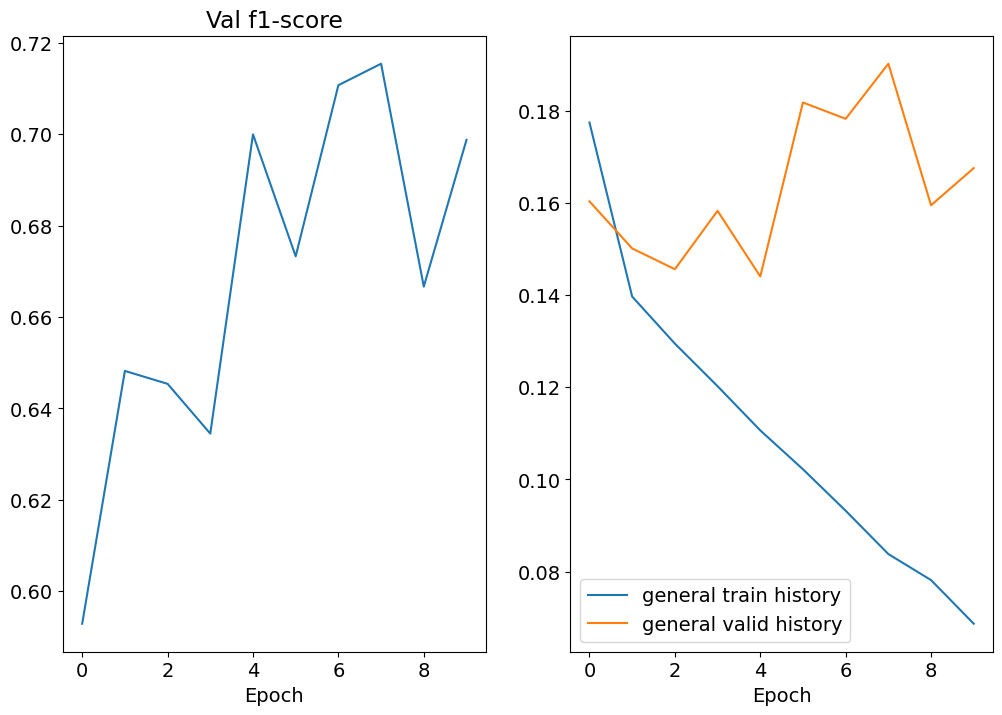

Epoch: 10 | Time: 15m 21s
	Train Loss: 0.069
	 Val. Loss: 0.168 |  Val. F1: 0.699


In [18]:
train_evaluate(bert_linearized_graph_clf, train_loader, dev_loader, optimizer, scheduler,
               criterion, N_EPOCHS, "bert_linearized_graph_clf", device)

In [39]:
true_labels, pred_labels, pred_probas = predict(bert_linearized_graph_clf, dev_loader, device)
print(f"{precision_score(true_labels, pred_labels)},{recall_score(true_labels, pred_labels)},{f1_score(true_labels, pred_labels)}")

0.8197879858657244,0.6089238845144357,0.6987951807228916


In [41]:
gc.collect()
torch.cuda.empty_cache()